In [3]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pickle
from matplotlib.colors import rgb2hex
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [4]:
data_dir = "../cpunks/data"
image_dir = "../cpunks/images/training"

In [5]:
def get_punk(id):
    '''
       Returns a ndarray with loaded image
    ''' 
    return mpimg.imread(f'''{image_dir}/punk{"%04d" % id}.png''')

def unique_color_alpha_vectors(image_array):
    # Reshape the image array to a 2D array where each row is a color-alpha vector
    reshaped_array = image_array.reshape(-1, image_array.shape[2])

    # Find unique rows (color-alpha vectors) in the reshaped array
    unique_vectors = np.unique(reshaped_array, axis=0)

    return unique_vectors

def find_unique_vectors_across_arrays(arrays):
    # Concatenate all arrays along the first two dimensions
    concatenated_array = np.concatenate([arr.reshape(-1, 4) for arr in arrays], axis=0)

    # Find unique rows (color vectors) in the concatenated array
    unique_vectors = np.unique(concatenated_array, axis=0)

    return unique_vectors

## load all 10k punks and find set of unique colors

In [6]:
x = [get_punk(i) for i in range(0,10000)]
all_colors = find_unique_vectors_across_arrays(x)

In [7]:

class ColorOneHotMapper:
    def __init__(self, unique_colors):
        self.color_to_one_hot = {}
        self.one_hot_to_color = {}

        for idx, color in enumerate(unique_colors):
            one_hot = np.zeros(len(unique_colors))
            one_hot[idx] = 1

            self.color_to_one_hot[tuple(color)] = one_hot
            self.one_hot_to_color[tuple(one_hot)] = color

    def get_one_hot(self, color):
        color_tuple = tuple(color)
        return self.color_to_one_hot.get(color_tuple, 
                                         "Color not found")

    def get_color(self, one_hot):
        one_hot_tuple = tuple(one_hot)
        return self.one_hot_to_color.get(one_hot_tuple, 
                                         "One-hot vector not found")



In [8]:

# Example usage
unique_colors = all_colors
mapper = ColorOneHotMapper(unique_colors)

# Test with a color
test_color = unique_colors[2]
test_one_hot = mapper.get_one_hot(test_color)
print("Color:", test_color)
print("One-hot encoding:", test_one_hot)

# Test with a one-hot vector
retrieved_color = mapper.get_color(test_one_hot)
retrieved_color

Color: [0.        0.2509804 1.        1.       ]
One-hot encoding: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


array([0.       , 0.2509804, 1.       , 1.       ], dtype=float32)

In [9]:

def convert_image_to_one_hot(image, mapper):
    # Initialize an empty array for the one-hot encoded image
    one_hot_encoded_image = np.zeros((image.shape[0], image.shape[1], len(mapper.color_to_one_hot)))
    
    # Iterate over each pixel and convert to one-hot encoding
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            color = image[i, j]
            one_hot = mapper.get_one_hot(color)
            if isinstance(one_hot, str):  # Check if color not found
                continue  # or handle the error as needed
            one_hot_index = np.argmax(one_hot)
            one_hot_encoded_image[i, j, one_hot_index] = 1

    return np.transpose(one_hot_encoded_image, (2, 0, 1))



In [10]:
#%%timeit
image = get_punk(0)
# Convert to one-hot encoded image
one_hot_encoded_image = convert_image_to_one_hot(image, mapper)

one_hot_encoded_image.shape

(222, 24, 24)

In [11]:
import os
from torch.utils.data import Dataset
import numpy as np
import torch

class OneHotEncodedImageDataset(Dataset):
    def __init__(self, directory, mapper):
        self.directory = directory
        self.mapper = mapper
        self.image_files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = mpimg.imread(image_path)
        # Assuming get_image returns a numpy array of shape (24, 24, 4)
        one_hot_encoded_image = convert_image_to_one_hot(image, self.mapper)
        return torch.tensor(one_hot_encoded_image, dtype=torch.float32)

def prepare_dataset(directory, mapper):
    return OneHotEncodedImageDataset(directory, mapper)


In [12]:


unique_colors = all_colors
mapper = ColorOneHotMapper(unique_colors)
dataset_directory = image_dir  

dataset = prepare_dataset(dataset_directory, mapper)



In [13]:
(type(dataset),
 len(dataset),
 dataset[0].shape)

(__main__.OneHotEncodedImageDataset, 10000, torch.Size([222, 24, 24]))

### prepare a dataloader

In [14]:
from torch.utils.data import DataLoader

# Assuming 'dataset' is your instance of OneHotEncodedImageDataset
batch_size = 32  # You can adjust the batch size as needed
shuffle = True  # Set to True to shuffle the dataset at every epoch
num_workers = 4  # Adjust based on your system's capabilities

dataloader = DataLoader(dataset, 
                        batch_size=batch_size, 
                        shuffle=shuffle, 
                        num_workers=0)


### Define the autoencoder model

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

class OneHotAutoencoder(nn.Module):
    def __init__(self):
        super(OneHotAutoencoder, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(24*24*222, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 24*24*222),
            nn.Sigmoid()  # Use sigmoid to ensure output is between 0 and 1
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(x.size(0), 24, 24, 222)  # Reshape back to the original shape
        return x
    
    def encode(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        encoded = self.encoder(x)
        return encoded


### define the convnet model

In [17]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.k = 3
        self.p = 1
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(222, 64, kernel_size=self.k, padding=self.p)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=self.k, padding=self.p)
        
        # Upsampling layers
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        
        # Output layer
        self.out_conv = nn.Conv2d(128, 222, kernel_size=self.k, padding=self.p)

    def forward(self, x):
        # Apply the first convolutional layer and activation function
        x = F.softmax(self.conv1(x))
        
        # Apply the second convolutional layer and activation function
        x = F.softmax(self.conv2(x))

        # Upsample the output of the convolutional layers
        #x = self.upsample(x)
        #x = self.upsample(x)
        
        # Apply the output layer with softmax activation
        x = F.softmax(self.out_conv(x), dim=1)
        return x

# Create the model
model = SimpleConvNet()



### Simple AutoEncoder/Decoder

this one does a good job after only 5 epochs and training was still improving

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(222, 128, kernel_size=3, stride=2, padding=1),  # Output: [128, 12, 12]
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1),   # Output: [64, 6, 6]
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1)     # Output: [32, 3, 3]
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: [64, 6, 6]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # Output: [128, 12, 12]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 222, kernel_size=3, stride=2, padding=1, output_padding=1) # Output: [222, 24, 24]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def decode(self, z):
        # Generate images from latent space representation
        return self.decoder(z)

# Create the autoencoder model
model = ConvAutoencoder()


#latent_representation = torch.randn(1, 32, 3, 3)  # Example latent space representation
#generated_image = autoencoder.decode(latent_representation)
#print("Generated Image Shape:", generated_image.shape)


In [ ]:
# Print model summary (requires additional package 'torchsummary' for formatted output)
#from torchsummary import summary
#summary(model, input_size=(222, 24, 24))

### setup the training loop

PyTorch's nn.Conv2d expects input in the format (batch_size, channels, height, width), but our dataloader used the format (batch_size, height, width, channels).

In [19]:
def train_autoencoder(model, dataloader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        running_loss = 0.0
        for data in dataloader:
            #print(data.shape)
            inputs = data
            #labels = labels.long()
            optimizer.zero_grad()
            outputs = model(inputs)
            #print(outputs.shape)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"epoch ... {running_loss}")

In [20]:


# Create the model instance
#autoencoder = OneHotAutoencoder()
#model = SimpleConvNet()
model = ConvAutoencoder()

# Assuming you have a DataLoader named 'dataloader'
train_autoencoder(model, dataloader, epochs=10)

epoch ... 356.9522985816002
epoch ... 116.51032209396362
epoch ... 47.86007644981146
epoch ... 26.313571635633707
epoch ... 16.256859550252557
epoch ... 10.899090509861708
epoch ... 7.935838439501822
epoch ... 5.581342494115233
epoch ... 4.27959600975737
epoch ... 3.3016623142175376


In [21]:
# pick an image  from the dataloader for validation
for batch in dataloader:
    # Assuming your batch contains input data and possibly labels/targets
    inputs = batch  # or batch['input'] depending on how your dataset returns a batch
    print("Shape of input:", inputs.shape)
    break  # We break the loop as we only want to check the shape of one batch
    


Shape of input: torch.Size([32, 222, 24, 24])


In [22]:
def get_one_hot(index, length):
    # Create a zero vector of the specified length
    one_hot_vector = np.zeros(length)
    
    # Set the value at the index to 1
    one_hot_vector[index] = 1
    
    return one_hot_vector

In [23]:
def decode_to_rgb(decoded_one_hot, mapper):
    # Choose the color with the highest probability for each pixel
    color_indices = np.argmax(decoded_one_hot, axis=-1)

    # Initialize an empty array for the RGB image
    rgb_image = np.zeros((color_indices.shape[0], color_indices.shape[1], 4))

    # Map each index back to an RGB color
    for i in range(color_indices.shape[0]):
        for j in range(color_indices.shape[1]):
            one_hot_vector = get_one_hot(color_indices[i, j], 222)
            rgb_image[i, j] = mapper.get_color(one_hot_vector)

    return rgb_image

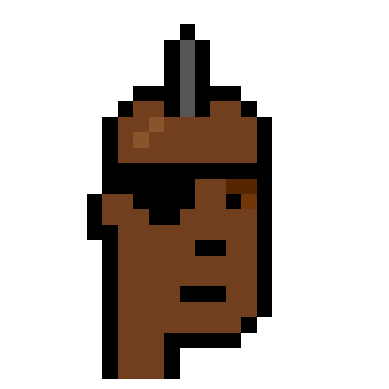

In [24]:
# Pass the image through the network
preprocessed_image = inputs
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output_image = model(preprocessed_image.squeeze(0))  # Add batch dimension

output_image[0].shape
decoded_one_hot = output_image[0]
# Permute the tensor to change the shape to (24, 24, 222)
permuted_tensor = decoded_one_hot.permute(1, 2, 0)

# Convert the permuted tensor to a numpy array
a = permuted_tensor.numpy()
img = decode_to_rgb(a, mapper)
plt.imshow(img)
plt.axis('off')
plt.show()

#### sample from latent space and plot

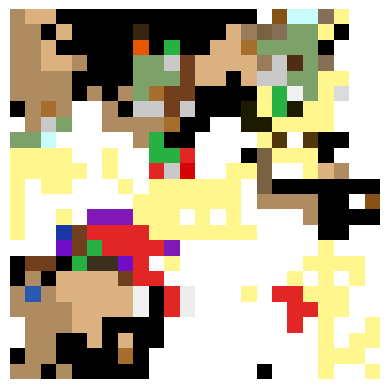

In [25]:
# Example usage
latent_representation = torch.randn(1, 32, 3, 3)  # Example latent space representation
generated_image = model.decode(latent_representation)
generated_image.shape
tensor_squeezed = generated_image.squeeze(0).permute(1, 2, 0)  # Now the shape is [24, 24, 222]

# Convert to a NumPy array
numpy_array = tensor_squeezed.detach().numpy()

img = decode_to_rgb(numpy_array, mapper)
plt.imshow(img)
plt.axis('off')
plt.show()